<a href="https://colab.research.google.com/github/omicsEye/waveome/blob/main/Gaussian_Process_Sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Gaussian Process Sampling
===

In [7]:
#@title Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [8]:
#@title Kernels

# Non-stationary

# Linear kernel (random slope)
def linear(x):
  return np.multiply.outer(x.to_numpy(), x.to_numpy())

# Brownian motion
def brownian(x):
  ax = np.abs(x.to_numpy())
  return np.minimum.outer(ax, ax)

# Stationary

# Uncorrelated noise
def noise(x):
  return np.eye(x.shape[0])

# Squared-exponential (radial basis kernel)
def sexp(x, l):
  return np.exp(-.5 * np.subtract.outer(x.to_numpy(), x.to_numpy())**2 / l**2)

# Ornstein-Uhlenbeck
def ou(x, l):
  return np.exp(-np.abs(np.subtract.outer(x.to_numpy(), x.to_numpy())) / l)

# A constant kernel (random offset)
def constant(x):
  return np.ones((x.shape[0], x.shape[0]))

# Categorical kernel
def cat(x):
  return np.where(np.equal.outer(x.to_numpy(), x.to_numpy()), 1., 0.)

# Standard periodic
def periodic(x, l, p):
  return np.exp(-np.sin(np.pi * np.subtract.outer(x.to_numpy(), x.to_numpy()) / p)**2 / l**2)

In [9]:
#@title Helper functions

# Generate input for a GP
def gen_input(units=1, conditions=1, time_points=200, time_range=(-10., 10.)):
  if units == 1:
    t = np.random.uniform(time_range[0], time_range[1], size=time_points)
    return pd.DataFrame(data={"time": t})

  unit_x = np.repeat(np.arange(units*conditions), time_points)
  t = np.random.uniform(time_range[0], time_range[1], size=len(unit_x))
  if conditions == 1:
    return pd.DataFrame(data={"unit": unit_x, "time": t})
  
  cond = np.repeat(np.tile(np.arange(conditions), units), time_points)
  return pd.DataFrame(data={"condition": cond, "unit": unit_x, "time": t})

# Sample from a GP
def sample_gp(cf, **kwargs):
  x = gen_input(**kwargs)
  C = cf(x)
  y = np.random.multivariate_normal(np.zeros(x.shape[0]), C)
  return x, y

# Plot helper
def plot_sample(x, y, points=False, same_color=False):
  fmt = '.' if points else '-'
  pl = None
  def plot_unit(t, y, fmt):
    nonlocal pl
    ord = np.argsort(t)
    if pl is not None and same_color:
      plt.plot(t[ord], y[ord], fmt, color=pl.get_color())
    else:
      pl, = plt.plot(t[ord], y[ord], fmt)

  if "condition" in x.columns:
    fmt2 = '^' if points else '--'
    units = np.unique(x.unit)
    for u in units:
      mask = x.unit == u
      plot_unit(x.time.to_numpy()[mask], y[mask], fmt if x.condition[mask].to_numpy()[0] == 0 else fmt2)
  elif "unit" in x.columns:
    units = np.unique(x.unit)
    for u in units:
      mask = x.unit == u
      plot_unit(x.time.to_numpy()[mask], y[mask], fmt)
  else:
    plot_unit(x.time.to_numpy(), y, fmt)

def plot_samples(cf, samples=5, units=1, points=False, **kwargs):
  if units == 1:
    for i in range(samples):
      plot_sample(*sample_gp(cf, units=1, **kwargs), points=points)
  else:
    for i in range(samples):
      plot_sample(*sample_gp(cf, units=units, **kwargs), points=points, same_color=True)


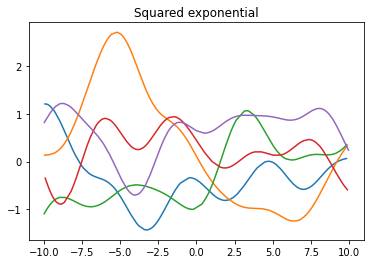

In [10]:
# Typical example of GPs - smooth wiggly lines!
# Each line is a sample from the GP

plot_samples(lambda x: sexp(x.time, 2.))
plt.title("Squared exponential");

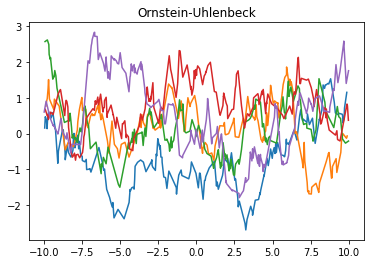

In [11]:
# More jagged process - Markovian though so more plausible stationary process for biological systems

plot_samples(lambda x: ou(x.time, 2.))
plt.title("Ornstein-Uhlenbeck");

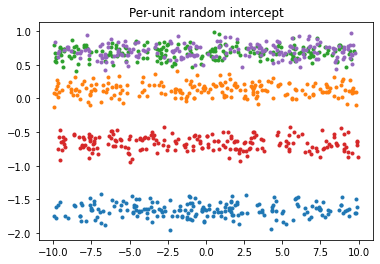

In [13]:
# Equivalent of a random effect model with random intercept

plot_sample(*sample_gp(lambda x: cat(x.unit) + 0.01 * noise(x), units=5), points=True)
plt.title("Per-unit random intercept");

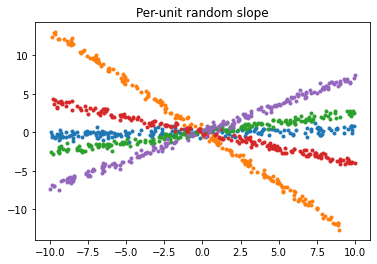

In [14]:
# Equivalent of a random effect model with random slope

plot_sample(*sample_gp(lambda x: cat(x.unit) * linear(x.time) + 0.1 * noise(x), units=5), points=True)
plt.title("Per-unit random slope");

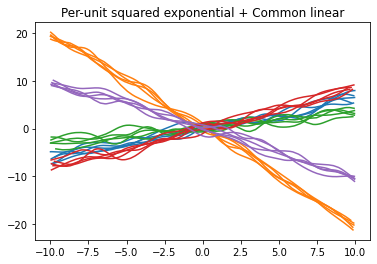

In [15]:
# More complicated example - a common linear component with within-unit wiggles
# Each line corresponds to one unit; each set of similarly-colored lines is now
# a separate sample from the GP.

plot_samples(lambda x: 0.5 * cat(x.unit) * sexp(x.time, 1.) + linear(x.time), units=5)
plt.title("Per-unit squared exponential + Common linear");

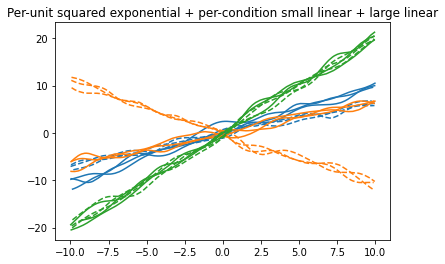

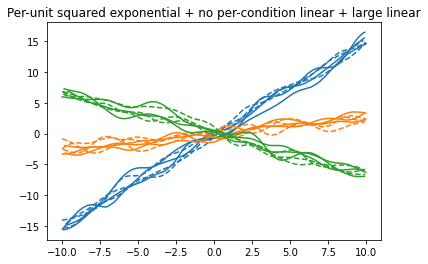

In [16]:
# Even more complicated:
# Two conditions (dashed and solid lines), which may or may not differ in output. E.g. patients treated with a drug (or not).
# Note that the first plot here has a difference, so the dashed and solid lines
# differ in mean slope, even if they're somewhat similar. In the bottom plot, they are the same.

plot_samples(lambda x: 0.5 * cat(x.unit) * sexp(x.time, 1.) + 0.4 * cat(x.condition) * linear(x.time) + linear(x.time),
             units=3, conditions=2, samples=3)
plt.title("Per-unit squared exponential + per-condition small linear + large linear");
plt.figure()
plot_samples(lambda x: 0.5 * cat(x.unit) * sexp(x.time, 1.) + 1.4 * linear(x.time),
             units=3, conditions=2, samples=3)
plt.title("Per-unit squared exponential + no per-condition linear + large linear");